In [3]:
import os
import glob
import zipfile
import os
import albumentations as A
import PIL
import cv2
import numpy as np
#from utils import plot_examples
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import glob
from sklearn.model_selection import train_test_split

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
os.chdir('../')

In [7]:
root_images = os.listdir('Downloads/new_train/Train/')[1:]
root_masks = os.listdir('Downloads/new_train/Mask/')[1:]

In [8]:
train_size = int(0.8 * len(root_images))
val_size = len(root_images) - train_size

In [9]:
train_images, val_images, train_masks, val_masks = train_test_split(root_images, root_masks, test_size=val_size)

In [10]:
class DRIVEdataset(Dataset):
    def __init__(self, images_dir, masks_dir, images_list, masks_list, my_transforms = None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.my_transforms = my_transforms
        self.images_list = images_list
        self.masks_list = masks_list
        
    def __getitem__(self, index):
        img = self.images_list[index]
        maska = self.masks_list[index]

        img_until_np = Image.open(os.path.join(self.images_dir, img)).convert('RGB')
        maska_until_np = Image.open(os.path.join(self.masks_dir, maska)).convert('L')

        if img_until_np.size != maska_until_np.size:
            maska_until_np = maska_until_np.resize(img_until_np.size)

        img_np = np.array(img_until_np, dtype = np.float32) / 255.0
        maska_np = np.array(maska_until_np, dtype = np.float32) / 255.0

        
        if self.my_transforms is not None:
            
            augmentations = self.my_transforms(image = img_np, mask = maska_np)
            img_np = augmentations['image']
            maska_np = augmentations['mask']
            maska_np = maska_np.unsqueeze(0)
            #img_np = img_np.unsqueeze(0)
            
        return img_np, maska_np


    def __len__(self):
        return len(self.images_list)

In [11]:
my_transforms_1 = A.Compose([
    #A.Normalize(normalization='image'),
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p = 0.9),
    A.VerticalFlip(p = 0.9),
    A.Rotate(limit = 45, p = 0.9),
    ToTensorV2()
])

In [12]:
my_transforms_2 = A.Compose([
    #A.Normalize(normalization='image'),
    A.Resize(height=256, width=256), 
    ToTensorV2()
])

In [13]:
train_dataset = DRIVEdataset('Downloads/new_train/Train/', 'Downloads/new_train/Mask/', images_list=train_images, masks_list=train_masks, my_transforms=my_transforms_1)

In [14]:
val_dataset = DRIVEdataset('Downloads/new_train/Train/', 'Downloads/new_train/Mask/',images_list=val_images, masks_list=val_masks, my_transforms=my_transforms_2)

In [15]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        #self.base_model.load_state_dict(torch.load("../input/resnet18/resnet18.pth"))
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3) # выход с 4го слоя [b_s, 512, 8, 8]

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)           #[512, 16, 16], layer3=[256, 16, 16]
        layer3 = self.layer3_1x1(layer3)     #[256, 16, 16]  
        x = torch.cat([x, layer3], dim=1)    #[768, 16, 16]
        x = self.conv_up3(x)              #layer2 = [128, 32, 32], x = [512, 16, 16]

        x = self.upsample(x)                #x=[512, 32, 32]
        layer2 = self.layer2_1x1(layer2)    #layer2 = [128, 32, 32]
        x = torch.cat([x, layer2], dim=1)   #x=[640, 32, 32]
        x = self.conv_up2(x)                  #x=[256, 32, 32]

        x = self.upsample(x)                 #x=[256, 64, 64]
        layer1 = self.layer1_1x1(layer1)    #layer1 = [64, 64, 64]
        x = torch.cat([x, layer1], dim=1)   #X=[320, 64, 64]
        x = self.conv_up1(x)                 #x=[256, 64, 64] 

        x = self.upsample(x)                 #x=[256, 128, 128]
        layer0 = self.layer0_1x1(layer0)   #layer0 = [64, 128, 128]
        x = torch.cat([x, layer0], dim=1)   #x=[320, 128, 128]
        x = self.conv_up0(x)                #x = [128, 128, 128]

        x = self.upsample(x)                 #x=[128, 256, 256]
        x = torch.cat([x, x_original], dim=1) #x_original=[64, 256, 256], x=[192, 256, 256]
        x = self.conv_original_size2(x)       #x=[64, 256, 256]

        out = self.conv_last(x)                #out=[1, 256, 256]

        return out


In [16]:
def train(model, loader, loss_fn, optimazer):
    train_loss = 0 
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimazer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimazer.step()

        
        train_loss += loss.item() * x.shape[0]
        
    loss_n = train_loss / len(train_dataset)
    return loss_n

In [17]:
model = UNet(1).to(device)
loader_tr = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=0)
loader_val = DataLoader(dataset=val_dataset, batch_size=16)
loss_fn = nn.BCEWithLogitsLoss()
optimazer = optim.Adam(model.parameters())

In [356]:
for i in range(20):
    result = train(model, loader_tr, loss_fn, optimazer)
    box_for_loss_tr.append(result)

    
    if i % 2 == 0:
        val_loss = 0
        for x_batch, y_batch in loader_val:
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            with torch.no_grad():
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                val_loss += loss.item() * x_batch.shape[0]
        box_for_loss_val.append(val_loss / len(val_dataset))
        print(f'ошибка на валидации = {val_loss / len(val_dataset)}, ошибка на трейне = {result}')

ошибка на валидации = 0.3960096836090088, ошибка на трейне = 0.10170174390077591
ошибка на валидации = 0.31631147861480713, ошибка на трейне = 0.11953579758604367
ошибка на валидации = 0.351261834303538, ошибка на трейне = 0.11746970564126968
ошибка на валидации = 0.3014071087042491, ошибка на трейне = 0.12022088219722112
ошибка на валидации = 0.3908613125483195, ошибка на трейне = 0.0938120037317276
ошибка на валидации = 0.45103426774342853, ошибка на трейне = 0.0907090629140536
ошибка на валидации = 0.37802208463350934, ошибка на трейне = 0.10185261070728302
ошибка на валидации = 0.3250280022621155, ошибка на трейне = 0.09390461941560109
ошибка на валидации = 0.3359641631444295, ошибка на трейне = 0.09868092089891434
ошибка на валидации = 0.30136945346991223, ошибка на трейне = 0.11145987610022227


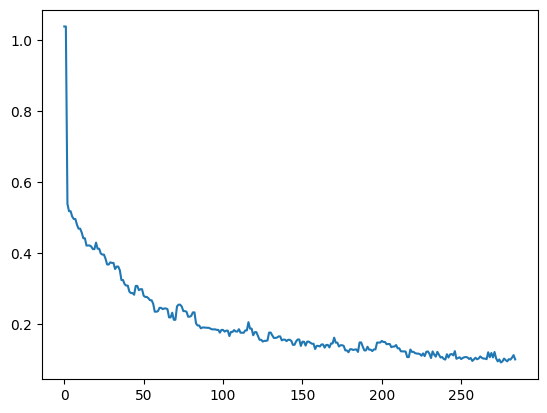

In [357]:
plt.plot(box_for_loss_tr)

In [19]:
to_PIL = transforms.ToPILImage()
m = nn.Sigmoid()

In [395]:
t = -60
for (x, y) in train_dataset:
    if t > 0:
        break
    t += 1

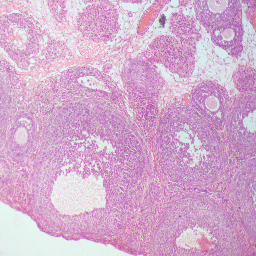

In [396]:
x_pil = to_PIL(x)
x_pil

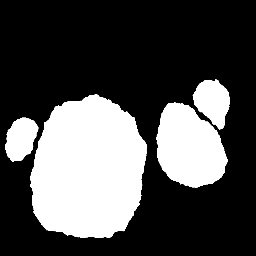

In [397]:
y_pil = to_PIL(y)
y_pil

In [398]:
x = x.unsqueeze(0).to(device)
x_preds = model(x)

In [399]:
h = m(x_preds)

In [400]:
torch.max(m(x_preds))

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)

In [401]:
torch.min(m(x_preds))

tensor(9.9851e-11, device='cuda:0', grad_fn=<MinBackward1>)

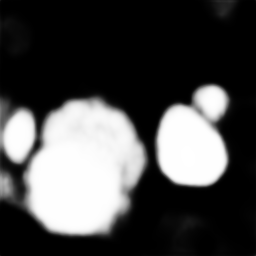

In [402]:
to_PIL(h.squeeze(0))

In [317]:
model_save_path = 'model.pth'

In [318]:
torch.save(
    {
        'model_state_dict':model.state_dict(),
        'optimazer_state_dict':optimazer.state_dict()
    }, 'model.pth'
)